In [1]:
import wandb
import numpy as np

In [2]:
project_name='Fashion_tuning_random'
wandb.login(key="5bfaaa474f16b4400560a3efa1e961104ed54810")
wandb.init(project=project_name)

wandb: Currently logged in as: aravind_iitm. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\PhysioSens\.netrc


In [3]:
import numpy as np
import keras
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt


# Loading the Fashion_mnist data

In [4]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


In [7]:
class_type = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
indx=[]
count=0
images=[]
labels=[]
class_label=[]
while len(indx)!=10:
    i=np.random.choice(range(X_train.shape[0]))
    
    img=X_train[i]
    label=y_train[i]
    
    if label not in indx:
        images.append(img)
        labels.append(label)
        indx.append(label)
        class_label.append(class_type[label])
        

# Plotting each sample 

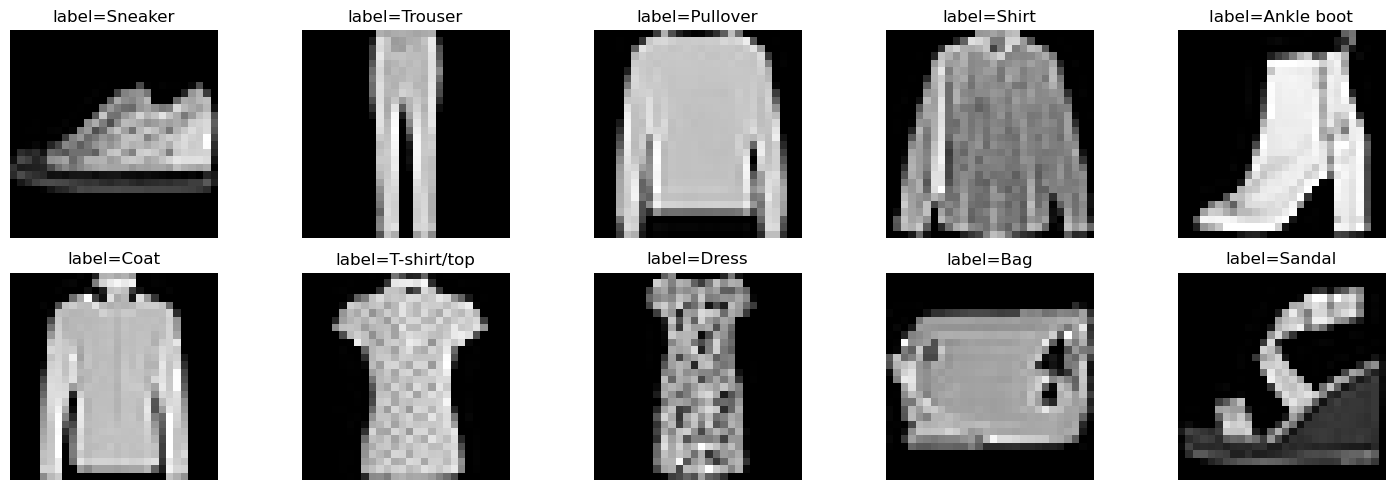

In [10]:
fig,axs=plt.subplots(2,5,figsize=(15,5))

for i,ax in enumerate(axs.flatten()):
    ax.imshow(images[i],cmap='gray')
    ax.set_title(f'label={class_label[i]}')
    ax.set_axis_off()
plt.tight_layout()
plt.axis('off')
plt.show()

In [11]:
wandb.log({'examples':[wandb.Image(img,caption=lab) for img,lab in zip(images,class_label)]})

In [7]:
x_train=np.zeros((X_train.shape[1]*X_train.shape[2],X_train.shape[0]))
x_test=np.zeros((X_test.shape[1]*X_test.shape[2],X_test.shape[0]))

for i in range(X_train.shape[0]):
    img=X_train[i]
    img=img.flatten()
    x_train[:,i]=img

for i in range(X_test.shape[0]):
    img=X_test[i]
    img=img.flatten()
    x_test[:,i]=img
x_train=x_train/np.max(x_train)
x_test=x_test/np.max(x_test)


In [8]:
def Sigmoid(z):
    return 1/(1+np.exp(-z))
def Relu(z):
    return np.maximum(0,z)
def Tanh(z):
    num=np.exp(z)-np.exp(-z)
    dem=np.exp(z)+np.exp(-z)
    
    return num/dem

def softmax(a):
    out=a.copy()
    for i in range(out.shape[1]):
        out[:,i]=np.exp(out[:,i]-np.max(out[:,i]))
        out[:,i]= out[:,i]/np.sum(out[:,i])
    return out
    
def deri_sigmoid(z):
    return z*(1-z)

def deri_relu(z):
    return np.int64(z>0)


def deri_tanh(z):
    return 1-(Tanh(z)*Tanh(z))

#-np.max(out[:,i])


In [9]:
def random_initialisation(size_hidden):
    weight=[]
    bais=[]
    for i in range(len(size_hidden)):
        if i==0:
            W=np.random.randn(size_hidden[i],x_train.shape[0])*.01
            b=np.zeros((size_hidden[i],1))
            weight.append(W)
            bais.append(b)
        else:
            W=np.random.randn(size_hidden[i],size_hidden[i-1])*.01
            b=np.zeros((size_hidden[i],1))
            weight.append(W)
            bais.append(b)
    return weight,bais

def xavier_initialisation(size_hidden):
    weight=[]
    bais=[]
    for i in range(len(size_hidden)):
        if i==0:
            W=np.random.randn(size_hidden[i],x_train.shape[0])*np.sqrt(2/(size_hidden[i]+x_train.shape[0]))
            b=np.zeros((size_hidden[i],1))
            weight.append(W)
            bais.append(b)
        else:
            W=np.random.randn(size_hidden[i],size_hidden[i-1])*np.sqrt(2/(size_hidden[i]+size_hidden[i-1]))
            b=np.zeros((size_hidden[i],1))
            weight.append(W)
            bais.append(b)
    return weight,bais


def forward_prop(X,W,B,act='sigmoid'):
    A=[]
    H=[]
    activations=['sigmoid', 'tanh', 'ReLU','identity']
    if act in activations:
        for i in range(len(W)):
            if i==0:
                a=(W[i]@X)+B[i]
                A.append(a)
                if act=='sigmoid':
                    h=Sigmoid(a)
                    H.append(h)
                elif act=='tanh':
                    h=Tanh(a)
                    H.append(h)
                elif act=='ReLU':
                    h=Relu(a)
                    H.append(h)
                elif act=='identity':
                    h=a.copy()
                    H.append(h)
                
            else:
                a=(W[i]@h)+B[i]
                A.append(a)
                if i+1!=len(W):
                    if act=='sigmoid':
                        h=Sigmoid(a)
                        H.append(h)
                    elif act=='tanh':
                        h=Tanh(a)
                        H.append(h)
                    elif act=='ReLU':
                        h=Relu(a)
                        H.append(h)
                    elif act=='identity':
                        h=a.copy()
                        H.append(h)
                else:
                    y=softmax(a)
                    H.append(y)
                
        return A,H
        
    else:
        raise ValueError('you have given a wrong activation function')
        

        
def one_hot(y):
    y_=np.zeros((10,len(y)))
    
    for i in range(y.shape[0]):
        label=y[i]
        y_[label,i]=1
    return y_
        
def back_prop(w,b,a,h,ypred,y_hot,x,act,loss_type):
    GRAD_h,GRAD_a,GRAD_w,GRAD_b=[],[],[],[]
    
    if loss_type=='cross_entropy':
        grad_a=-(y_hot-ypred)
        grad_h=0
    elif loss_type=='mean_squared_error':
        grad_a=(ypred-y_hot)*ypred*(1-ypred)
        grad_h=0
    else:
        raise ValueError('Loss function not found')
    
    GRAD_a.append(grad_a)
    GRAD_h.append(grad_h)
    N=x.shape[1]
    
    activations=['sigmoid', 'tanh', 'ReLU','identity']
    if act in activations:
    
        for z,i in enumerate(range(len(h)-1,-1,-1)):


            if z==0:
                GRAD_w.append((GRAD_a[z]@h[i-1].T)/N)
                GRAD_b.append((np.sum(GRAD_a[z],axis=1,keepdims=True))/N)
            elif i!=0:
                grad_h=w[i+1].T@GRAD_a[z-1]
                if act=='sigmoid':
                    grad_a=grad_h*deri_sigmoid(h[i])
                elif act=='ReLU':
                    grad_a=grad_h*deri_relu(h[i])
                elif act=='tanh':
                    grad_a=grad_h*deri_tanh(h[i])
                elif act=='identity':
                    grad_a=grad_h

                GRAD_h.append(grad_h)
                GRAD_a.append(grad_a)

                GRAD_w.append((GRAD_a[z]@h[i-1].T)/N)
                GRAD_b.append((np.sum(GRAD_a[z],axis=1,keepdims=True))/N)
            else:
                grad_h=w[i+1].T@GRAD_a[z-1]
                if act=='sigmoid':
                    grad_a=grad_h*deri_sigmoid(h[i])
                elif act=='ReLU':
                    grad_a=grad_h*deri_relu(h[i])
                elif act=='tanh':
                    grad_a=grad_h*deri_tanh(h[i])
                elif act=='identity':
                    grad_a=grad_h
                GRAD_h.append(grad_h)
                GRAD_a.append(grad_a)

                GRAD_w.append((GRAD_a[z]@x.T)/N)
                GRAD_b.append((np.sum(GRAD_a[z],axis=1,keepdims=True))/N)
                
    else:
        raise ValueError('you have given a wrong activation function')
            
            
    return GRAD_w[::-1],GRAD_b[::-1]


def cost(y_hot,y_pred,w,w_d,loss_type):
    if loss_type=='cross_entropy':
    
        loss=np.multiply(y_hot,y_pred)
        loss=np.sum(loss,axis=0)
        loss=-1*np.sum(np.log(loss))
        loss=loss/y_pred.shape[1]
    elif loss_type=='mean_squared_error':
        loss=np.sum((y_pred-y_hot)**2)
        loss=loss/y_pred.shape[1]
    
    weight_loss=0
    for weight in w:
        weight_loss+=(w_d/2)*np.sum(weight**2)
    
    
    return loss+weight_loss




def sgd(grad_w,w,grad_b,b,lr,w_d):
    w_update=[]
    b_update=[]
    for i in range(len(w)):
        w_update.append(w[i]*(1-lr*w_d)-lr*grad_w[i])
        b_update.append(b[i]*(1-lr*w_d)-lr*grad_b[i])
        
    return w_update,b_update
    
            
def momentum(grad_w,w,grad_b,b,lr,iter_,prev_grad_w,prev_grad_b,beta,w_d):
    if iter_==0:

        w_update=[]
        b_update=[]
        prev_grad_w=[]
        prev_grad_b=[]
        for i in range(len(w)):
            w_update.append(w[i]*(1-lr*w_d)-lr*grad_w[i])
            b_update.append(b[i]*(1-lr*w_d)-lr*grad_b[i])
            prev_grad_w.append(lr*grad_w[i])
            prev_grad_b.append(lr*grad_b[i])

        return w_update,b_update,prev_grad_w,prev_grad_b
    else:
        w_update=[]
        b_update=[]
        for i in range(len(w)):
            update_w=(lr*grad_w[i]+beta*prev_grad_w[i])
            update_b=(lr*grad_b[i]+beta*prev_grad_b[i])
            w_update.append(w[i]*(1-lr*w_d)-update_w)
            b_update.append(b[i]*(1-lr*w_d)-update_b)
            prev_grad_w[i]=update_w
            prev_grad_b[i]=update_b

        return w_update,b_update,prev_grad_w,prev_grad_b
    
def nag(grad_w,w,grad_b,b,lr,iter_,prev_grad_w,prev_grad_b,beta,w_d,x,y_hot,activation,loss_type):
    if iter_==0:

        w_update=[]
        b_update=[]
        prev_grad_w=[]
        prev_grad_b=[]
        for i in range(len(w)):
            w_update.append(w[i]*(1-lr*w_d)-lr*grad_w[i])
            b_update.append(b[i]*(1-lr*w_d)-lr*grad_b[i])
            prev_grad_w.append(lr*grad_w[i])
            prev_grad_b.append(lr*grad_b[i])

        return w_update,b_update,prev_grad_w,prev_grad_b
    
    else:
        w_update=[]
        b_update=[]
        w_look=[]
        b_look=[]
        for i in range(len(w)):
            update_w=(beta*prev_grad_w[i])
            update_b=(beta*prev_grad_b[i])
            w_look.append(w[i]*(1-lr*w_d)-update_w)
            b_look.append(b[i]*(1-lr*w_d)-update_b)
        A,H=forward_prop(x,w_look,b_look,act=activation)
        back_prop(w,b,A,H,H[-1],y_hot,x,activation,loss_type)
        grad_w,grad_b=back_prop(w_look,b_look,A,H,H[-1],y_hot,x,activation,loss_type)
        
        for i in range(len(w)):
            prev_grad_w[i]=beta*prev_grad_w[i]+lr*grad_w[i]
            prev_grad_b[i]=beta*prev_grad_b[i]+lr*grad_b[i]
            
            w_update.append(w[i]*(1-lr*w_d)-prev_grad_w[i])
            b_update.append(b[i]*(1-lr*w_d)-prev_grad_b[i])

        return w_update,b_update,prev_grad_w,prev_grad_b
        
def rmsprop(grad_w,w,grad_b,b,lr,iter_,vt_w,vt_b,beta,w_d):
    
    if iter_==0:
        eps=1e-8

        w_update=[]
        b_update=[]
        vt_w=[]
        vt_b=[]
        for i in range(len(w)):
            vt_w.append((1-beta)*grad_w[i]**2)
            vt_b.append((1-beta)*grad_b[i]**2)
            
            div_w=(1/np.sqrt(vt_w[i]+eps))
            div_b=(1/np.sqrt(vt_b[i]+eps))
            
            w_update.append(w[i]*(1-lr*w_d)-(lr*div_w)*grad_w[i])
            b_update.append(b[i]*(1-lr*w_d)-(lr*div_b)*grad_b[i])
            

        return w_update,b_update,vt_w,vt_b
    else:
        eps=1e-8
        w_update=[]
        b_update=[]
        
        for i in range(len(w)):
            vt_w[i]=beta*vt_w[i]+(1-beta)*(grad_w[i]**2)
            vt_b[i]=beta*vt_b[i]+(1-beta)*(grad_b[i]**2)
            
            '''
            div_w=(lr/np.sqrt(vt_w[i]+eps))
            div_b=(lr/np.sqrt(vt_b[i]+eps))
            '''
            
            div_w=np.multiply(lr,np.reciprocal(np.sqrt(vt_w[i]+eps)))
            div_b=np.multiply(lr,np.reciprocal(np.sqrt(vt_b[i]+eps)))
            
            
            w_update.append(w[i]*(1-lr*w_d)-div_w*grad_w[i])
            b_update.append(b[i]*(1-lr*w_d)-div_b*grad_b[i])
        return w_update,b_update,vt_w,vt_b
        

    
        
def ADAM(grad_w,w,grad_b,b,lr,iter_,vt_w,vt_b,beta1,mt_w,mt_b,beta2,ep,w_d):
    if iter_==0:
        eps=1e-8

        w_update=[]
        b_update=[]
        vt_w=[]
        vt_b=[]
        mt_w=[]
        mt_b=[]
        for i in range(len(w)):
            
            vt_w.append((1-beta2)*grad_w[i]**2)
            vt_b.append((1-beta2)*grad_b[i]**2)
            
            mt_w.append((1-beta1)*grad_w[i])
            mt_b.append((1-beta1)*grad_b[i])
            

            
            vt_w_=vt_w[i]/(1-np.power(beta2,ep+1))
            vt_b_=vt_b[i]/(1-np.power(beta2,ep+1))
            
            
            
            mt_w_=mt_w[i]/(1-np.power(beta1,ep+1))
            mt_b_=mt_b[i]/(1-np.power(beta1,ep+1))
            
            w_=mt_w_/(np.sqrt(vt_w_+eps))
            b_=mt_b_/(np.sqrt(vt_b_+eps))
            
            
            w_update.append(w[i]*(1-lr*w_d)-(lr*w_))
            b_update.append(b[i]*(1-lr*w_d)-(lr*b_))
            

        return w_update,b_update,mt_w,mt_b,vt_w,vt_b
    else:
        eps=1e-8
        w_update=[]
        b_update=[]
        
        for i in range(len(w)):
            

            vt_w[i]=vt_w[i]*beta2+(1-beta2)*grad_w[i]**2
            vt_b[i]=vt_b[i]*beta2+(1-beta2)*grad_b[i]**2
            
            
            mt_w[i]=beta1*mt_w[i]+(1-beta1)*grad_w[i]
            mt_b[i]=beta1*mt_b[i]+(1-beta1)*grad_b[i]
            
        
            
            vt_w_=vt_w[i]/(1-np.power(beta2,ep+1))
            vt_b_=vt_b[i]/(1-np.power(beta2,ep+1))
            
            mt_w_=mt_w[i]/(1-np.power(beta1,ep+1))
            mt_b_=mt_b[i]/(1-np.power(beta1,ep+1))
            
            w_=mt_w_/(np.sqrt(vt_w_+eps))
            b_=mt_b_/(np.sqrt(vt_b_+eps))
            
            
            w_update.append(w[i]*(1-lr*w_d)-(lr*w_))
            b_update.append(b[i]*(1-lr*w_d)-(lr*b_))
        
        return w_update,b_update,mt_w,mt_b,vt_w,vt_b
    

    
def NADAM(grad_w,w,grad_b,b,lr,iter_,vt_w,vt_b,beta1,mt_w,mt_b,beta2,ep,w_d,x,y_hot,activation,loss_type):
    if iter_==0:
        eps=1e-8

        w_update=[]
        b_update=[]
        vt_w=[]
        vt_b=[]
        mt_w=[]
        mt_b=[]
        for i in range(len(w)):
            
            vt_w.append((1-beta2)*grad_w[i]**2)
            vt_b.append((1-beta2)*grad_b[i]**2)
            
            mt_w.append((1-beta1)*grad_w[i])
            mt_b.append((1-beta1)*grad_b[i])
            

            
            vt_w_=vt_w[i]/(1-np.power(beta2,ep+1))
            vt_b_=vt_b[i]/(1-np.power(beta2,ep+1))
            
            
            
            mt_w_=mt_w[i]/(1-np.power(beta1,ep+1))
            mt_b_=mt_b[i]/(1-np.power(beta1,ep+1))
            
            w_=mt_w_/(np.sqrt(vt_w_+eps))
            b_=mt_b_/(np.sqrt(vt_b_+eps))
            
            
            w_update.append(w[i]*(1-lr*w_d)-(lr*w_))
            b_update.append(b[i]*(1-lr*w_d)-(lr*b_))
            

        return w_update,b_update,mt_w,mt_b,vt_w,vt_b
    else:
        eps=1e-8
        w_update=[]
        b_update=[]
        w_look=[]
        b_look=[]
        
        for i in range(len(w)):
            w_look.append(w[i]-beta1*mt_w[i])
            b_look.append(b[i]-beta1*mt_b[i])
            
        A,H=forward_prop(x,w_look,b_look,act=activation)
        grad_w,grad_b=back_prop(w_look,b_look,A,H,H[-1],y_hot,x,activation,loss_type)
        
        for i in range(len(w)):

            
            mt_w[i]=beta1*mt_w[i]+(1-beta1)*grad_w[i]
            mt_b[i]=beta1*mt_b[i]+(1-beta1)*grad_b[i]
            
            
            
            vt_w[i]=vt_w[i]*beta2+(1-beta2)*grad_w[i]**2
            vt_b[i]=vt_b[i]*beta2+(1-beta2)*grad_b[i]**2
            
            
        
            
            vt_w_=vt_w[i]/(1-np.power(beta2,ep+1))
            vt_b_=vt_b[i]/(1-np.power(beta2,ep+1))
            
            mt_w_=mt_w[i]/(1-np.power(beta1,ep+1))
            mt_b_=mt_b[i]/(1-np.power(beta1,ep+1))
            
            w_=mt_w_/(np.sqrt(vt_w_+eps))
            b_=mt_b_/(np.sqrt(vt_b_+eps))
            
            
            w_update.append(w[i]*(1-lr*w_d)-(lr*w_))
            b_update.append(b[i]*(1-lr*w_d)-(lr*b_))
        
        return w_update,b_update,mt_w,mt_b,vt_w,vt_b
            
      

In [10]:
x_train.shape,y_train.shape

((784, 60000), (60000,))

In [11]:
shuffle_num=np.arange(x_train.shape[1])
np.random.shuffle(shuffle_num)

In [12]:
train_shuffle=shuffle_num[0:int(x_train.shape[1]*.9)]
val_shuffle=shuffle_num[int(x_train.shape[1]*.9):]

In [13]:
x_val,y_val=x_train[:,val_shuffle],y_train[val_shuffle]
x_train,y_train=x_train[:,train_shuffle],y_train[train_shuffle]

In [14]:
x_train.shape,y_val.shape,y_train.shape,x_val.shape

((784, 54000), (6000,), (54000,), (784, 6000))

In [15]:
def train_NN(optimizer,lr,w_d,num_layers,hidden_size,batch_size,loss_type,weight_init,activation,epochs):
    size_hidden=[]
    for z in range(num_layers):
        size_hidden.append(hidden_size)
    size_hidden.append(10)

    beta1=.9
    beta2=.999
    beta=.9
    m=.5
    train_loss=[]
    val_loss=[]
    train_acc=[]
    val_acc=[]

    prev_grad_w=[]
    prev_grad_b=[]
    vt_w=[]
    vt_b=[]
    mt_w=[]
    mt_b=[]
    if weight_init=='random':
        w,b=random_initialisation(size_hidden)
    elif weight_init=='xavier':
        w,b=xavier_initialisation(size_hidden)
    else:
        raise ValueError('Given Initiatisation not found')
    for ep in range(epochs):
        curr_train_loss=[]
        curr_train_acc=[]

        for i in range(0,len(y_train),batch_size):
            if i==0 and ep==0:
                iter_=0
            else:
                iter_=1
            if i+batch_size>len(y_train):
                break
            else:
                x,y=x_train[:,i:i+batch_size],y_train[i:i+batch_size]


                A,H=forward_prop(x,w,b,act=activation)
                y_hot=one_hot(y)

                curr_train_loss.append(cost(y_hot,H[-1],w,w_d,loss_type))

                grad_w,grad_b=back_prop(w,b,A,H,H[-1],y_hot,x,activation,loss_type)

                if optimizer=='sgd':
                    w,b=sgd(grad_w,w,grad_b,b,lr,w_d)
                elif optimizer=='momentum':
                    w,b,prev_grad_w,prev_grad_b=momentum(grad_w,w,grad_b,b,lr,iter_,prev_grad_w,prev_grad_b,m,w_d)
                elif optimizer=='nag':
                    w,b,prev_grad_w,prev_grad_b=nag(grad_w,w,grad_b,b,lr,iter_,prev_grad_w,prev_grad_b,m,w_d,x,y_hot,activation,loss_type)

                elif optimizer=='rmsprop':
                    w,b,vt_w,vt_b=rmsprop(grad_w,w,grad_b,b,lr,iter_,vt_w,vt_b,beta,w_d)
                elif optimizer=='adam':
                    w,b,mt_w,mt_b,vt_w,vt_b=ADAM(grad_w,w,grad_b,b,lr,iter_,vt_w,vt_b,beta1,mt_w,mt_b,beta2,ep,w_d)

                elif optimizer=='nadam':
                    w,b,mt_w,mt_b,vt_w,vt_b=NADAM(grad_w,w,grad_b,b,lr,iter_,vt_w,vt_b,beta1,mt_w,mt_b,beta2,ep,w_d,x,y_hot,activation,loss_type)


                else:
                    raise ValueError('Wrong Optimizer Given')



                acc=(np.argmax(H[-1],axis=0)==y).sum()

                curr_train_acc.append(acc/len(y))

        train_loss.append(np.average(curr_train_loss))

        train_acc.append(np.average(curr_train_acc))



        A,H=forward_prop(x_val,w,b,act=activation)
        y_hot=one_hot(y_val)
        val_loss.append(cost(y_hot,H[-1],w,w_d,loss_type))
        acc=(np.argmax(H[-1],axis=0)==y_val).sum()

        val_acc.append(acc/len(y_val))


        wandb.log({"Train_Accuracy":np.round(train_acc[ep]*100,2),"Train_Loss":train_loss[ep],
                   "Val_Accuracy":np.round(val_acc[ep]*100,2),"Val_Loss":val_loss[ep],"Epoch":ep})
            
            

In [16]:
sweep_config={
    'method':'random',
    'metric':{
        'name':'Val_Accuracy',
        'goal':'maximize'},

}



parameters_dict={
    'optimizer':{
        'values':['adam','nadam','sgd','momentum','nag','rmsprop']
    },
    'lr':{
        'values':[1e-3,1e-4,1e-5]
    },
    'reg':{
        'values':[0,5e-1,5e-4]
    },
    'n_hiddenlayer':{
        'values':[3,4,5,6]
    },
    'hl_size':{
      'values':[32,64,128]  
    },
    'batch_size':{
        'values':[16,32,64]
    },
    'loss_type':{
        'values':['cross_entropy','mean_squared_error']
    },
    'initialization':{
        'values':['xavier','random']
    },
    'activation':{
        'values':['sigmoid','tanh','ReLU']
    },
    'n_epoch':{
        'values':[5,10,15]
    },
}
sweep_config['parameters']=parameters_dict

In [17]:
def train():
    wandb.init()
    config=wandb.config
    wandb.run.name = "op_"+str(config.optimizer)+"_ac_"+str(config.activation)+"_hl_"+str(config.hl_size)+"_bs_"+str(config.batch_size)                                         
    parameters=train_NN(config.optimizer,config.lr,config.reg,config.n_hiddenlayer,config.hl_size,config.batch_size,config.loss_type,config.initialization,config.activation,config.n_epoch)
    
    wandb.finish()


In [ ]:
wandb.init()
sweep_id=wandb.sweep(sweep_config,project=project_name)
wandb.agent(sweep_id,train)
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: x9t78ltp
Sweep URL: https://wandb.ai/aravind_iitm/Fashion_tuning_random/sweeps/x9t78ltp


wandb: Agent Starting Run: 7kq8t32d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


Exception in thread ChkStopThrException in thread :
Exception in thread IntMsgThrTraceback (most recent call last):
NetStatThr:
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 980, in _bootstrap_inner
:
Traceback (most recent call last):
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 980, in _bootstrap_inner
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 917, in run
        self.run()self.run()    

self._target(*self._args, **self._kwargs)  File "C:\ProgramData\Anaconda3\lib\threading.py", line 917, in run
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 917, in run

  File "C:\Users\PhysioSens\AppData\Roaming\Python\Python39\site-packages\wandb\sdk\wandb_run.py", line 286, in check_stop_status
    self._target(*self._args, **self._kwargs)
  File "C:\Users\PhysioSens\AppData\Roaming\Python\Python39\site-packages\wandb\

wandb: Agent Starting Run: 1w40byim with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 1n1m67r8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jo6j3ooa with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ijjsm0gs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: w75e0r0z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: 12ckhcbp with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: f4kw8250 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 3oseb0oh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 4cxlm320 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: b2j25pfq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r0gzhqgc with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: vvf3qf8w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 21krvfnf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8opn5ecr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: beqa135g with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c1i95rih with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: yssmoqjm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 20oq31e0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: u9owjlmq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: nur90srr with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: rbft7egy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1csfj6w2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 74zkevmc with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: zoxsucp8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: v0n01pe7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: rvajb5k7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 2dvxgsvy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: tb8qg0tz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: cxagqi63 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: ndhrhap5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r5woz17w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: 8ngith54 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 0qd2vr2t with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nho706qa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2yj54ye7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: xqira6sy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: f3k1e0qc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: fplwbugk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: socu1zo7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: cnema1qq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: 6q6brdey with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1e244oju with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: kro2g8bo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 64vjj53w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: by82ljuh with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: ud8vem1y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: qlnq91vd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n5mdo4cd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ckizabqs with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: ii40d7du with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: qddzqnxm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: iwklqqoz with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: g2pozpuk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: pykss5ae with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: yxzdd7v4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: z93g1gl8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: nbgksfuy with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: n2752531 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: ocbaeyi7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: s6of2v2t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: u55dzp7z with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: p4eoth2x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: s9s8mxc4 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: yoplvym7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: zwq5zryj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 7brfomav with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: l47v3kme with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: kaqallrg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: b3q7sv6o with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: eo6is083 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: tfywsuvz with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: zmsihlq1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: o2ijrk0e with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: bwcwsch7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: hxnkoc5m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: qru9deof with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tyixrssi with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: uyuukhew with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: cdsmbzqn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: ve7ge6yl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: m5nip0xj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: ebexubm9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: jghvgzoz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jad3hpqo with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: sg340w1e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: waz2zr3b with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: zy90tz85 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zmu12fte with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 92odm8if with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 8unkuxm4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: u7vti6k0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: 9xvlx9ht with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cffocve4 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: j3cifmx3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ppb3ha7p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: wwnt8i08 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jq0hyqum with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 112vih9j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 4t86o9vj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: 8r4zyulq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: m1f049j9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: svwzdd0e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: zcg4igj5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: djzuulhz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: o9ffqz9g with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: 88yljnav with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 818f9783 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: ka9bgpy1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: ppgkk94x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: z410g9zi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: fmdwwuf4 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 4kkvkujy with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5cvrm2ps with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: ftuskjan with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 3xtic7zt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: kz36fcql with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: f72iu1xz with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xjrymhdn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 7p1imee6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 28x3ww76 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4d9zlapr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 6oh1b1p3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: yp27aagb with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9deonjh5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: hr04vvi1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pn92r1gi with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zqj22pkb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: d2xr7fok with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rh3u7gyh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: m8p157me with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: gylk72nf with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xsfzk6p6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: lskk9sfo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: rr84o6jg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: x65v74hn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: shfros8e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: l4qqfbqo with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: gvuxrwqd with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pznhlfd5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: l1l4bvh6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 1aei16bz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: 2pir1a46 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: bmfphx4o with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 4i32jpms with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: ru8atuqu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 57spevtr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ai2sritz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: jl85kwxz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: xi3lh3jh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: 7x95nmrv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: ovc7xwy6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5yhjauuf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 6p8dj6ds with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: 3d9fz2ge with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: vww31g57 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: g06bvpzw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: btu44idb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: frpkjd7s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 7pwa2y3q with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: mcjrx4lk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 6958zj60 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: q8fughf1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: iu1okg5n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: dhm24zho with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 57evc42f with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n59ag5mo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: shenxao1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: zrxz5pyd with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: gwhsv7ew with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: cjj1kdbj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: u3e75th4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: rk8y2g5k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ho9p8ui4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: q15ubfjq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: m2w47hhl with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 7aao7kh9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: r6cfqf5h with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: 801z7puj with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 19cviivq with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: l8y2b8bk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: of97ux0i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1j2au750 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a8qzec81 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 3r22y8j5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 8mx9151i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: cej7k1nh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: rosky9gn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: lox0c13a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 34sxjjwf with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: 4x8hidn3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: eq4asoch with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8m9rj1s4 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: 6p2tnho8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mlvqoe88 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: qbkqp21i with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: ts2tdlwc with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: 2gy91h7r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: lted0c9g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: cue8m5k1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xb1toaev with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: ile2dymu with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 8gy3cp0f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 62cv70u3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: iayrg1ba with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 6qp41763 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: j14uk3fd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j49tiq9l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 8d11fij1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: o8xzm7o0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: cw9hf8xf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: obn186n2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: fjg2h4nz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: bzgsv457 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: zqjiyw7t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: pnsoj8iw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: amqwgoao with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: ar9ebw0c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: kc0n8dxy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: lw6xweie with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: 3ue1jf62 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: rxn66j8l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: wmhwgshx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: xijfg1ts with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: l1q4y5mf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 9tlonfod with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: u4vgal14 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: py0xjxb3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: zouzjz02 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: eh7w425l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: h1opzvkx with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: hn1dcvhj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: sg3q3kas with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: ci3dj19t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: ftm75bmv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: r0ng1tv1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: kxeg1za0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: nfhn669p with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 5t0kgsjy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: j1h0itwv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 5jfat3zj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: ouz8rz1h with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: qc76sgby with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


C:\Users\PhysioSens\AppData\Local\Temp\ipykernel_23132\3542037296.py:6: RuntimeWarning: overflow encountered in exp
  num=np.exp(z)-np.exp(-z)
C:\Users\PhysioSens\AppData\Local\Temp\ipykernel_23132\3542037296.py:7: RuntimeWarning: overflow encountered in exp
  dem=np.exp(z)+np.exp(-z)
C:\Users\PhysioSens\AppData\Local\Temp\ipykernel_23132\3542037296.py:9: RuntimeWarning: invalid value encountered in divide
  return num/dem


wandb: Agent Starting Run: v5g0ip5b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: fn3i6geq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 2a0arihb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: xzb3ijzv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: wscpywib with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: lw7vus1r with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hnx60bmf with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: unmcfs5q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: a8e4yki5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: sucucg9n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: veu2m5e4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 69deduyp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 413zn6po with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: fdosia8z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: zc6lpmx5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: gegxunrb with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: pltz0b7b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: h3sd4pzi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f3neu4r5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: tlgrc518 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: jnactwmn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: knuhayio with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lmnxwwyt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: 6y5xk1y1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ndfr3rpv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 16zvugqy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 0jauyq2r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: scz572vd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7moww21b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ygvqv2qd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: qms362k3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: txaai98x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: eq30ll1w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 3kq1tqsk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: molg40a5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: 0ntstxla with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 8wey5mag with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 7uadjiav with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: jz1xy8oa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zsgyyy93 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: lwreuqq0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 1s4ad4ao with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: f4b0s7gu with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: cxuv38nr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: x6qiuqxk with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: fm32cn5h with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8hsuti6t with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: md2989sk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lwva0eog with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: okboknsd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: ade9yc0x with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: lz0f5zq8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 46b5y3vc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: cnbebppl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 3zh1irxt with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: un7kgkut with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: kafzvz87 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: pxkpyu93 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: w0kpcs6u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 84cdxluk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 3noq0x31 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: j5lb9r3a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: kvufwsvd with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l9pfa3v5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: 1rips82v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r0q0dy5s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: 5ajt5py9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: szenxknw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2c2rxp4p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: dzivflwt with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ykvnvm1n with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n95til1q with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: o5o3csa8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 8k6qavjj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: ooj8wkxj with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: q8oz4owe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: l0zvvpoj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ag1olxr8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: ex777v34 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 29h1xf8l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 7j3b7ry5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wsvj436b with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: 1vyvyjnx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 3gyuupze with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 16q95vm3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 826tve6w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: w32uv4g8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: rpaf73pv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 2hwoaqst with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jxaymvcs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 1i3po7op with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: m9t43pq0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ht4vwipw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: 92du074g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: x14ehnse with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: is6nl6jg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: sl4926iw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 31p4ngjq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: q7z2cc7p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: xbcg24c6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: e0bg6vb4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: cycsjqhx with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 33wci4ar with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 6zhmw892 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 38vs0hpz with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 64ptejgb with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: na53eg3x with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 373orcy8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 9tzxzgn9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pgqfl0k1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r4d2vxqf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 0eee82kq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: citmddsb with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: 99y5kgyl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: j282a1zu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: cis3tcz9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 2yjjy866 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: w7aefarj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fd3h31u7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 0isyagm9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 47b0p1sn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: rdqdyp2j with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: c0c99orj with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0ii0qkyq with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bgxghksz with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: gj8e2eae with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: xw94xwe5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w8vah4n0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 0zqw4x3x with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: k6xo3cx5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: frld99gx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 3jvkjv0l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: sdgxupj2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: wfv9ma7c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: v04p8p8b with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: weor8r5w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: madt1c2c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: qu9dbu0b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: cowexqr6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: smjedkfh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: uk3vopwh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: ybccjptv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: z6m2tpbq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: 53hscpin with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: i1i1sgvp with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d8anbp94 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: w2e09gnn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 7g5qdkzc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: w5yqd2th with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: ysjgyjhn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: pnamnyjb with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ig9pmth4 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: jpb7wxlh with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: zg9kcwjx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: cjemhv9q with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: pp18spb4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 2kxnacut with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 6me4egxt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 1cd1zh55 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: am3prhus with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: tg9qt81l with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3dyd9s3o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: o2eidasv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: kfjg3yue with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: i4r08zbn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: ryfnvmbv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: nsgddnvv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: tpvhjm4q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: nx8a0lpn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lex8gdy5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: urlzr9sf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 4g395a1b with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 3iiswcq0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 44jtn95i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: yqluwxho with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: xkh51yyc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: o9rzqjoy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 4shmszat with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 4789pp8j with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: n00wu9jd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: tuu5zyuf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: k0coks8f with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: nflw6qsk with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: mg71kxmm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: a2umpusv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: mu6aqm3a with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 34w1dq40 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rxff27fx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lwwnraxv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2y0xqzbk with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 5da90a18 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: lqxyi2p8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1wfwv8wd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: unmpk56f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: pb01ykfs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: l47kjb7q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 0rzcwm40 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: ogj2ecet with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: epa7g5lf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: f7unmh8q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: spwh1gnv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: yiy9oxyu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 8mkkfv33 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: 44ciqr4c with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: z82jz86k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 7f8hitb1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 4tpdns6l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: m2yaf22t with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: mtw0h342 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: bl0aoo68 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wq4n9l6t with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: evsy6mge with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 8eyyszfa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j28kn9l8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0dncoxeb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: zsnm4phk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: vp6ez1t7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eun56log with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 03vj4e9c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: pv2we9cw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: m6vz74cd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: ohilrgc1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 12f2xaov with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: ruds6u9x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: cjm6azqf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: sbsecc34 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: b3de7dzc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t4jvtykb with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: cce50qj0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: filt43nz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7vzjsf58 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 4r1hxaf7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: jac2pcep with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 0c2p8n9v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: dsc8emmq with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: wwzhpyla with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 5fxidh33 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cl2oe0iz with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: j49ijvtp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: varleo84 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: dthnf6uf with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: 73kd1tyv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a4few9i3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: 88mlas1p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: a4of4u1p with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8s8qwy9q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iifd7yai with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 1ccrvgjn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: vhtc6mu8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: 5u17xz8g with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 11wmel9k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x9gbtk8o with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: wpmta8y1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: adb2jx07 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: lscgwiu7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: nqimoxvy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 1qgmahxw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: fajybuvj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 893som9b with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 68d63w8g with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 18pg2hv2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 74c52ugu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: zqscc93p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: cez8hgap with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: hl1d4966 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: jzqot9bs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: 308m16s2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: zpnh0ajm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 4v9hu0k0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9q6pcfj8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: o895pos9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: m5v8a6u9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 26h37upk with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iozenss2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: yz4reel6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: harcbvnc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: iho8976a with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: hee2o4u8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: gdkfgq9q with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: fkwsy7po with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: txp97khp with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: b5j6co9c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: b1i3n23o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: 2sp4g3ql with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: io6vxxfc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: cwkqygzt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: qsb4hygz with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: o49svs9b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7ihr0ifo with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: c44ll5qy with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: s1kgjwj4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: rgggukm7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tv4erqy7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: mpodow4a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: weul1cmt with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s1kkzvap with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: r8ktir1a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: bbdn29u9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: i6659b6k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 0l2emwy7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: xib97k1s with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 3utjzkb2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 3p0es0cv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 3k1kloij with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 5ocrprr8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: a2vr751o with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: vuuap3y2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: bgdg786y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 7hgz6zd7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: tjgzfjli with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: oht1df3m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: k0hugtc9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 4kif89qk with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 6zbok8ye with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: b2wuh2wy with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: vhqaxxhu with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: uj3ejsog with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: a3kqlrm7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: ctkegop7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: cohhnfg4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: dy1cf5ux with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 73j4xbf3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: gph1sivq with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: 3vvjhds0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: h6clxtak with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 340w8o5b with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: v3r5aq8j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: dk3j5cuf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: lfrhij2z with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1rsbmy1c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: v40597cj with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: dc50wzup with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: d4gee15g with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: f8u0rqyx with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: hh40b77p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: dfy39smy with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: r1lq787w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ruzs4wc with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: rujk3ef6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: yz31z1oy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: ouhnspbj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: yvgwf3e7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: eoip6bx1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tqqom1e2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vp3wbuio with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 2mtmhmul with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: jjp2wc56 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 4itvtgso with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6z5ndtu0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: u0y5pbb5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jnhqow9p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 09yp9wov with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 53b37gqz with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: cvzw08x1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jgn4lssk with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: lido3l3h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: shkx1cof with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: eqb4npxb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 6bjdcw84 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 5w4xmove with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: tur6lfcr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 618ypy1i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: k9nnzvug with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: e0bjvpsj with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b57yyl00 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ssrw5pmf with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rt2rxeis with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: e1w6hz49 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7c7umxt8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pmaex3hc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: d7jufbrw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: vvln4sle with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: f5zhw9wh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: r4l9869y with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dhngngpb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: zujcc5u1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: hvwiifzk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: uqdrylee with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: sz3d8g42 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: piaichne with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: xplpf3ae with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: gfh5ikxt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: yl35so07 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: vczb46qh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: awb16pwi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: kfvaimbk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: osbawky7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: abv4gw8c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: h03ndimz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ja22sxvy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 7bhj7ye3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: tfw5jk7q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: j8in3gj0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: v87r40ub with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: yyq07ldw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: ch0434jd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dsnv67jw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7b16e9w4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 8ej6iuot with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: q938l4qr with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: kludjmyy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: yo5va4j7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: rfzvuslv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e8uhdio2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: b3mawi9p with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5j0gowjf with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 1p46dckz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: x9y0fg2r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kw2r0a6u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: z9mozlzy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: x2v3d0ih with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: cnvze1ub with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: x131atg2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ftddok4t with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g96udx9u with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: c3pac8jf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 07w2x7ng with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 1gv4ctxd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: hjl0xu1x with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: mkhtro55 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 89ax1c1s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 3qcqh9ko with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 86u88ihi with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: vk68axmx with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 7txn7d3j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: pz02khgs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: wj00iqic with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: g6hm3l0w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: rncvfpjr with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: yutbd3je with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0karzi2b with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: cwq7uoyd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: goctjdrq with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: vxxifh3l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 51w4wh13 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: jim2wmbr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eyzf6eln with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: jetr7as1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: fil14e0u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ccqj1a37 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: mvo2b66g with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rr9u7p4p with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: 0hmzv1r0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ydvc4yr8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sxto6g82 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: fc3q5dsi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 7h1pmdx6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 3rs68ynu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 1bqsybk4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: kzgtstd1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: qihzf93i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qsis6kib with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: u8cn6mdn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yrom8iy0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: i43bkrp9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cap7ve1a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nt8wscr4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: zoel1s7e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 7mr4mbdi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: raih7bve with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: r3tpijnw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: suvctav7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 7ez884bh with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: ns8h1avj with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 656kb6jy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 5fp47cd2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: jo35tv6k with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lcinb633 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: cj39g58w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: azaus7ne with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: oado9g8k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ikjcag3y with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: 8au8n734 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: zwcu7wsd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: gyor4p71 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: nf2zsyoq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 8lv732h8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6hflqxn9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: f6z6mtdh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: xb6bfhpq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ryrqx61g with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9tx7ylif with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: p9np31gb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: pxx7kyhf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: yncabig3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: t6xb0reb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ho2iigao with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 9qkhswzd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 8d8rgncy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: kumfpvsb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: hyvcl6bl with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: 130qcwmz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xmu8b5au with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 75cv67q9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: 3vl250cw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: ccojgfm5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 5ggh37kp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: wt5iz8cj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jb0m0fj6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: dhxyp4zb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: xvjo02bm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hyqq1sov with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 15o4xtru with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: jvaf25v2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: px02ijs8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: hg32ctq0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 0j3vdtkb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 11najj8f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: cs33vyth with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: h9z2p7rl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 4fl5akji with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: v4tax9ev with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: 157bhzoo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: hoo2w5fe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 94quvf2t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 28f9hz3s with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: u84yj25r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: hi5riai5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 7qfgoa1z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: s7d1cw16 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: vjj4egft with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: e3gp4sok with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ytk269ar with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: jffp3xgr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: rdll2mu6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 6bsjjcv8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 2o8laep4 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: 2ck1tgzc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: nwi1mttg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: sn78e82h with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: 6a2dildz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: qy3cpyuh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: sz9u4dko with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y87pihmm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: hb1e16de with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 4cykdjex with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 1xm6cdgg with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 5yqdfqqn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: 0uyi3sar with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: bkyr2dev with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 3crc7y2n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 7qyegi9f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: if4n9g53 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: q7mm5dop with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: af596dp0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: 7tymbhd1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: nbxairr1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: rbff28s3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: xlnrpckh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: w64gcyq6 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 12xv64y2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: lhqfkqfe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: nrr1rf4x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: m5m4i156 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: x1klvssz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 5rdp46up with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: kwntn51h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: qwkio0w9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: dd8ntjl7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kldecdax with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: bvtiwiq2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: csrhgf4i with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: vtbhx9ug with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: x1fg8fi1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 9bairf3q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vytcq2j6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: dvsjcb0q with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 8rdokgjc with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: owuigzka with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: wjezmk19 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: t9aqni25 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: mhilq2yy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: yhu4ezsw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: s53l1xl2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: kde4bk36 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xx6bvrxn with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: p56qk07d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: w9ifgel1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f11bc137 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: k05rsukv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 5wfkcu8m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: oeowdw5t with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: d0gfqe92 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 3br2a21n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: vwd7312a with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 4h8jhacv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: vv2ywk8r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: sou0x4h1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2y2kpjw8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 5f3wd5sf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: hbb3oesf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: qhitt5y7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 5rralng4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: zdp2ggtg with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: asxcx6s7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 3jkzczjh with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 4kehj8je with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 8xh92bc9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 06k2c68l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: bl9y97z7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: raygzjpe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: dx6ru49i with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 6yj2cqcw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ojuw2lsn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: suyo8kse with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: xhegjx7b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1zjivdx5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: ttuyah8m with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m53mu6uj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: hlknq1vj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: mclbpuez with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: vwh2zqle with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: s06559nq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: fbgh0laa with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: bmxievn9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 2f4oxvg7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: ee73w077 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ydv4rpz2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vrqqebc1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: rw21wan3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: y3izftzd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: o3c6zya5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: fetlkatz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: p5hk24g7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: sky13poe with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d9g9t53m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: chmi145i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: zgf0u402 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: ku6nfga2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: nh7en423 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 8r1eimcw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: yep64gx1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: chysaa96 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: 7322ow7c with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 8gsoys4n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 6f943r5x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 69akvem3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: ehb5al87 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 05h3wg2p with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: s46u4y8r with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h94ez0l2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: uq4owuk2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: 5o0yk6is with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: ipclvs4p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: sogor6ww with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: e9mcl5pb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: j9wsjh9p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 9u3gpvce with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 01yz0j5q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: lj5uurlc with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 8hg9uop7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: k9jjmw7w with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: owebfws2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: gsvgql3r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: dajfuw44 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: gm9uek6o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ucb3ijuk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 4d7r4yf2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: wb9wfrlf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 09ifw7fw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: d32qjb7v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: ve11b8uw with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: t8j698qr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 4oxa3ozd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 30inzlr0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 6d1mu08y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: eir9mipv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: hiogo952 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: fg47as9q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: peldflb7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 005uyj3q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fvwjjhb7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: lc1zy7f8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: i6n9k05a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: 6g78wi0x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: blp2iaqg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: r581ka0l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 02aby2fu with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ine260r6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: kbqngb33 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: oqcyer5y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: t587pr0w with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ti6evste with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: rlsgn7nx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: c1sk2apk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 1adprfav with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: cx6mjzer with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: v7ghm0xx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z7rasoux with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: fr85k4jj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: 7ublx5eo with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 7ub128fj with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yelbd0xn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: vgtar8dr with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ev8fhgrw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: sbw5onfo with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: o0sh20tz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: weh0l4cw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 6b7svl9w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dsz0er3z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: r8jfq5ba with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: pa2wd377 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: la1xgjt6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: nz9i7ty1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: gcpbpvwd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 1qoc2ugi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x6hlh437 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: cs11tyo5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: cqxw7o96 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: k6g4rhaa with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: bmnh2r1f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: ih60rkmx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: i1t882mm with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 77v03k0o with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 1mj14z3o with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: igiwmybp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 761u11j9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: cyy0g1fs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: 1xrtf90a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: b52ji8oj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: e8mcpq7p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 1zpuwpon with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: fduxlt74 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 3kvu559l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: 84visq3q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: 3b2rbd6g with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 3dcjtd71 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 1hz0429j with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: v20tto19 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: dwzi4jxu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 8tluui2j with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 09i0z0qv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: wuyh3pqa with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iaecoe0n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 7pm6r7nk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: y5bx7tad with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: peo7m91t with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: yv7xjlqp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: zsx5jzi5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: 166rx95m with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: f0ctn6rx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: ieptbz7y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: dsd5cn33 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uevm9ohl with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: maoui7vk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: gwx0kjmk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: hljxmh8v with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 3fotz1qp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: d0shy5hu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: dj614d5a with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 2i2to64m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 45lxu66r with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: nfjwot50 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: afon5j7n with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zygjtkug with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: pg5sf5e6 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zuaib1z5 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: epatl6d3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: rkj6jtkr with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 89x372lh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 642h5t9h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: cefjipr8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: lo0aeyal with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: jp98rhc0 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: vcmw20q1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: iufwvnz9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: jjyn2tuq with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: c5ppf1f9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: f5m2kpyf with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: a9fag88y with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: vqx3ksww with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: wwrn5pbp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pxo0br8g with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: vqfaofh3 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8qphkg0q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: 1tmqwdg9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bris13tr with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9r5cy82e with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 5mocc7fi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 2svluizj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jvzc9ncy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: 5mk7j73q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: 5g7kfcuv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: ohxvzif6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: 0jdu1d67 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 70igmu2l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: a15hmo2q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: lm8tixcp with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0.5


wandb: Agent Starting Run: vkork4wh with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: kc7eos0o with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: hrtc80ec with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: 8hdq9oog with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nag
wandb: 	reg: 0.5


wandb: Agent Starting Run: 8mdvr40v with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 87a15wzd with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: sokr8opv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: u644o8bw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Agent Starting Run: j1gs04e1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: mgighx11 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: sygt069r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: q9z6buj0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: adam
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c4jnxcs5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: sgd
wandb: 	reg: 0


wandb: Agent Starting Run: 2eg4urui with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: m2u3o3f8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 2huef7p8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: 0z7xs5v2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: g1obry50 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 3v5rloe2 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: 5ey3al02 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eql6esmd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: rof4u2it with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 6irex3y9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.0001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: r8ycqqv8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: cmo1s6y2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w5z47gtz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Agent Starting Run: 9y1dbkqv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


wandb: Agent Starting Run: rhkdr9ow with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nag
wandb: 	reg: 0


wandb: Agent Starting Run: 74b1mrqs with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gx4macb5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 2pztqwvh with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


wandb: Agent Starting Run: h39xctwd with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: adam
wandb: 	reg: 0


wandb: Agent Starting Run: orf3olru with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


wandb: Agent Starting Run: rtj6dnce with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


wandb: Agent Starting Run: 9vev6d4h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0.0005


wandb: Agent Starting Run: s3mkmk9s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


wandb: Agent Starting Run: e2t4t0t3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nag
wandb: 	reg: 0.0005


wandb: Agent Starting Run: 41zgk53y with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: gg3i5xfk with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: hh7bw4ls with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 0.0001
wandb: 	n_epoch: 10
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 44hhgskv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: mean_squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 6
wandb: 	optimizer: nadam
wandb: 	reg: 0


wandb: Agent Starting Run: 26nr8yaj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


wandb: Agent Starting Run: zqo8hgfx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 15
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nag
wandb: 	reg: 0


In [7]:
ground_truth=np.load('ground_truth.npy')
predictions=np.load('ypred.npy')
class_names=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal","Shirt", "Sneaker","Bag","Ankle boot"]

In [8]:
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=ground_truth, preds=predictions,
                        class_names=class_names)})
